2023-05-24 17:59:19.518902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 17:59:19.616544: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-24 17:59:20.027046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/hcladmin/anaconda3/lib/:/home/hcladmin/anaconda3/lib/:/home/hcladmin/anaconda3/lib/
2023-05-24 17:59:20.027100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic librar

Number of train images:  15265
Number of train masks:  15265
knee image id: '329637-8_10.jpg' -- Corressponding Mask id '329637-8_10.jpg'
knee image id: '390116-9_7.jpg' -- Corressponding Mask id '390116-9_7.jpg'
knee image id: '404663-8_10.jpg' -- Corressponding Mask id '404663-8_10.jpg'
knee image id: '329637-8_17.jpg' -- Corressponding Mask id '329637-8_17.jpg'
knee image id: '329637-8_14.jpg' -- Corressponding Mask id '329637-8_14.jpg'
knee image id: '329637-8_12.jpg' -- Corressponding Mask id '329637-8_12.jpg'
knee image id: '329637-8_21.jpg' -- Corressponding Mask id '329637-8_21.jpg'
knee image id: '329637-8_5.jpg' -- Corressponding Mask id '329637-8_5.jpg'
Image Size:  (320, 320)
Mask Size:  (320, 320)
Training images size:  11448
Validation images size:  3817
Images batch shape:  (32, 128, 128, 3)
Masks batch shape:  (32, 128, 128, 3)
Images batch shape:  (32, 128, 128, 3)
Masks batch shape:  (32, 128, 128, 3)


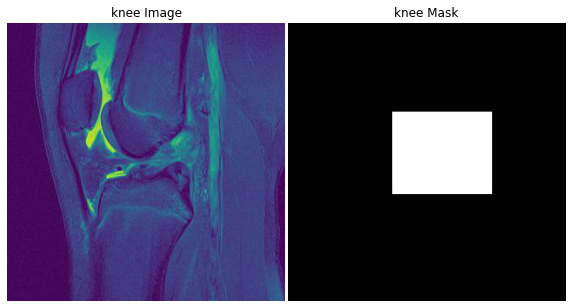

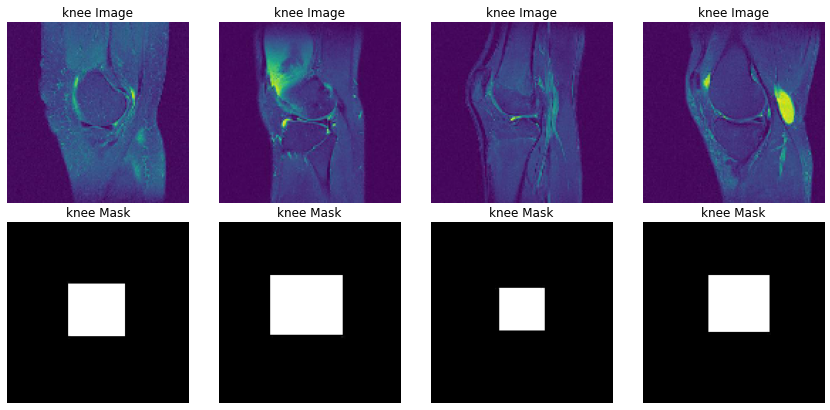

In [1]:
import os, keras
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from keras import backend as K
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.regularizers import l2
data_size = len(os.listdir('/home/hcladmin/Ahsen ALi/'))
print('Number of train images: ', len(os.listdir('/home/hcladmin/Ahsen ALi/newimages')))
print('Number of train masks: ', len(os.listdir('/home/hcladmin/Ahsen ALi/newmasks/')))
#Display ids for images and masks.
knee_ids = sorted(os.listdir('/home/hcladmin/Ahsen ALi/newimages'))
mask_ids = sorted(os.listdir('/home/hcladmin/Ahsen ALi/newmasks'))
#Generate some random index.
rnd_ind = list(np.random.choice(data_size,8))
for i in rnd_ind:
    print("knee image id: '{}' -- Corressponding Mask id '{}'".format(knee_ids[i], mask_ids[i]))
#Pick the 1553th car&mask ids from ids lists.
n = 1553
knee_id = knee_ids[n]
mask_id = mask_ids[n]
#Load car&mask images using thier ids.
knee = load_img('/home/hcladmin/Ahsen ALi/newimages/' + knee_id)
mask = load_img('/home/hcladmin/Ahsen ALi/newmasks/' + mask_id)
print("Image Size: ", knee.size)
print("Mask Size: ", mask.size)
#Plot them.
fig, ax = plt.subplots(1, 2, figsize=(10,10))
fig.subplots_adjust(hspace=.1, wspace=.01)
ax[0].imshow(knee)
ax[0].axis('off')
ax[0].title.set_text('knee Image')
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].title.set_text('knee Mask')
#Input size could be 128 or 256 or 512 or 1024.
input_size = [128, 128, 3]
def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    '''
    images_path/masks_path: Images/Masks folder directory.
    images_ids/mask_ids: Ids for '.jpg' images/masks.
    img_size: Generated imgs/masks size.
    
    returns: batch of randomly-selected car&mask images value-scaled (0 -> 1). 
    '''
    data_size = len(image_ids)
    while True:
        #Choose random indice for later picking.
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        masks = []
        for i in rnd_ind:
            #Pick a random id for car&mask images.
            img_id, mask_id = image_ids[i], mask_ids[i]
            #Load/resize images.
            img = load_img(images_path + img_id, target_size=img_size) 
            mask = load_img(masks_path + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            #Add to the batch data.
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.
#Randomly split car&mask ids list to training and validation lists.
#X is car image ids list, y is mask image ids list.
X_train_ids, X_val_ids, y_train_ids, y_val_ids= train_test_split(knee_ids, mask_ids,
                                                                 test_size=.25, train_size=.75,
                                                                 random_state=42)
X_train_size = len(X_train_ids)
X_val_size = len(X_val_ids)
print('Training images size: ', X_train_size)
print('Validation images size: ', X_val_size)
#Try out the generator, generate data samples from the validation set.
gen = data_generator('/home/hcladmin/Ahsen ALi/newimages/', '/home/hcladmin/Ahsen ALi/newmasks/',
                    X_val_ids, y_val_ids, batch_size=32)

imgs, masks = next(gen)
print('Images batch shape: ', imgs.shape)
print('Masks batch shape: ', imgs.shape)
#Input size could be 128 or 256 or 512 or 1024.
input_size = [128, 128, 3]
def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    '''
    images_path/masks_path: Images/Masks folder directory.
    images_ids/mask_ids: Ids for '.jpg' images/masks.
    img_size: Generated imgs/masks size.
    
    returns: batch of randomly-selected car&mask images value-scaled (0 -> 1). 
    '''
    data_size = len(image_ids)
    while True:
        #Choose random indice for later picking.
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        masks = []
        for i in rnd_ind:
            #Pick a random id for car&mask images.
            img_id, mask_id = image_ids[i], mask_ids[i]
            #Load/resize images.
            img = load_img(images_path + img_id, target_size=img_size) 
            mask = load_img(masks_path + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            #Add to the batch data.
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.
#Try out the generator, generate data samples from the validation set.
gen = data_generator('/home/hcladmin/Ahsen ALi/newimages/', '/home/hcladmin/Ahsen ALi/newmasks/',
                    X_val_ids, y_val_ids, batch_size=32)

imgs, masks = next(gen)
print('Images batch shape: ', imgs.shape)
print('Masks batch shape: ', imgs.shape)
#Plot output samples of the generator.
fig, ax = plt.subplots(2, 4, figsize=(15,7))
fig.subplots_adjust(hspace=.1, wspace=.05)
knee_samples, mask_samples = imgs[:4].astype(np.float32), masks[:4][:,:,:,0].astype(np.float32)
for i, (knee, mask) in enumerate(zip(knee_samples, mask_samples)):
    ax[0, i].imshow(knee)
    ax[0, i].axis('off')
    ax[0, i].title.set_text('knee Image')
    
    ax[1, i].imshow(mask, cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].title.set_text('knee Mask')
plt.show() 
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
def iou(true_y, pred_y):
    def f(true_y, pred_y):
        intersection = (true_y * pred_y).sum()
        union = true_y.sum() + pred_y.sum() - intersection
        x = (intersection)/(union)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [true_y, pred_y], tf.float32)
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
#Prepare callbacks
LR_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=10, factor=.2, min_lr=.00001)
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)
#Perpare data generators.
batch_size = 32
train_gen = data_generator('/home/hcladmin/Ahsen ALi/newimages/', '/home/hcladmin/Ahsen ALi/newmasks/',
                           X_train_ids, y_train_ids, batch_size=batch_size)
val_gen = data_generator('/home/hcladmin/Ahsen ALi/newimages/', '/home/hcladmin/Ahsen ALi/newmasks/',
                           X_val_ids, y_val_ids, batch_size=batch_size)

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x

def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = Conv2D(512, 1, padding="same", use_bias=False)(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)
    attention_weights = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='attention_weights')(y3)

    # Scale the input features by the attention weights
    attended_features = y3 * attention_weights

    # Sum the attended features along the channel dimension
    attended_features = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1, keepdims=True))(attended_features)

    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([y3, attended_features])

    # Pass the concatenated features through a few more convolution layers
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same')(concatenated_features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    # ... add more layers as needed

    # Create the model
    # model = tf.keras.Model(input_features, x)
    y6 = Conv2D(1024, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y6 = BatchNormalization()(x)
    y6 = Activation("relu")(x)

    y = Concatenate()([y1, y2,x,y6])

    """ 3x3 conv rate=12 """
    # y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    # y4 = BatchNormalization()(y4)
    # y4 = Activation("relu")(y4)
    # y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    # y5 = BatchNormalization()(y5)
    # y5 = Activation("relu")(y5)
    """ 3x3 conv rate=18 """
    y6 = Conv2D(1024, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y6 = BatchNormalization()(y3)
    y6 = Activation("relu")(y3)

    attention_weights = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='attention_weights')(y6)

    # Scale the input features by the attention weights
    attended_features = y6 * attention_weights

    # Sum the attended features along the channel dimension
    attended_features = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1, keepdims=True))(attended_features)

    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([y6, attended_features])
    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([y3, attended_features])

    # Pass the concatenated features through a few more convolution layers
    z = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same')(concatenated_features)
    z = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Activation('relu')(x)

    attention_weights = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='attention_weights')(z)

    # Scale the input features by the attention weights
    attended_features = z * attention_weights

    # Sum the attended features along the channel dimension
    attended_features = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1, keepdims=True))(attended_features)

    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([z, attended_features])
    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([z, attended_features])

    # Pass the concatenated features through a few more convolution layers
    alpha= tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same')(concatenated_features)
    alpha= tf.keras.layers.BatchNormalization()(x)
    alpha= tf.keras.layers.Activation('relu')(x)



    attention_weights = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='attention_weights')(alpha)

    # Scale the input features by the attention weights
    attended_features = z * attention_weights

    # Sum the attended features along the channel dimension
    attended_features = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1, keepdims=True))(attended_features)

    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([alpha, attended_features])
    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([alpha, attended_features])

    # Pass the concatenated features through a few more convolution layers
    beta= tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same')(concatenated_features)
    beta= tf.keras.layers.BatchNormalization()(x)
    beta= tf.keras.layers.Activation('relu')(x)



    y = Concatenate()([beta])
    y = Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def deeplabv3_plus(shape):
    """ Input """
    inputs = Input(shape)

    """ Encoder """
    encoder = tf.keras.applications.vgg19.VGG19(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        classes=1000,
        classifier_activation='softmax'
    )

    
    image_features = encoder.get_layer("block5_conv4").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("block3_conv4").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)


    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)


    attention_weights = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='attention_weights')(x)

    # Scale the input features by the attention weights
    attended_features = x * attention_weights

    # Sum the attended features along the channel dimension
    attended_features = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1, keepdims=True))(attended_features)

    # Concatenate the attended features with the original input features
    concatenated_features = tf.keras.layers.Concatenate()([x, attended_features])
    # Concatenate the attended features with the original input features
    # concatenated_features = tf.keras.layers.Concatenate()([x, attended_features])

    x = UpSampling2D((4,4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

if __name__ == "__main__":
    model = deeplabv3_plus((128,128, 3))

2023-05-24 17:59:32.611665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 17:59:32.631926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 17:59:32.632089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 17:59:32.632598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
model.compile(optimizer=Adam(lr=0.0001), loss=bce_dice_loss, metrics=["acc", iou, dice_coeff, dice_loss, recall_m, precision_m, f1_m])

/home/hcladmin/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [5]:
history=model.fit_generator(train_gen, steps_per_epoch=int(X_train_size/batch_size),epochs=30, validation_data=val_gen,validation_steps=int(X_val_size/batch_size),callbacks=[LR_callback, EarlyStop_callback])

Epoch 1/30


/tmp/ipykernel_937229/3844107742.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen, steps_per_epoch=int(X_train_size/batch_size),epochs=30, validation_data=val_gen,validation_steps=int(X_val_size/batch_size),callbacks=[LR_callback, EarlyStop_callback])
2023-05-24 17:59:59.356403: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-05-24 18:00:00.692332: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


357/357 [==============================] - 67s 167ms/step - loss: 0.3654 - acc: 0.9674 - iou: 0.5921 - dice_coeff: 0.7321 - dice_loss: 0.2679 - recall_m: 0.9153 - precision_m: 0.8506 - f1_m: 0.8756 - val_loss: 0.2730 - val_acc: 0.9734 - val_iou: 0.6623 - val_dice_coeff: 0.7968 - val_dice_loss: 0.2032 - val_recall_m: 0.9547 - val_precision_m: 0.8300 - val_f1_m: 0.8878 - lr: 1.0000e-04
Epoch 2/30
357/357 [==============================] - 58s 162ms/step - loss: 0.1632 - acc: 0.9783 - iou: 0.7852 - dice_coeff: 0.8796 - dice_loss: 0.1204 - recall_m: 0.9118 - precision_m: 0.9113 - f1_m: 0.9113 - val_loss: 0.1545 - val_acc: 0.9782 - val_iou: 0.7999 - val_dice_coeff: 0.8888 - val_dice_loss: 0.1112 - val_recall_m: 0.9281 - val_precision_m: 0.8942 - val_f1_m: 0.9107 - lr: 1.0000e-04
Epoch 3/30
357/357 [==============================] - 58s 163ms/step - loss: 0.1372 - acc: 0.9794 - iou: 0.8194 - dice_coeff: 0.9007 - dice_loss: 0.0993 - recall_m: 0.9187 - precision_m: 0.9189 - f1_m: 0.9185 - val_

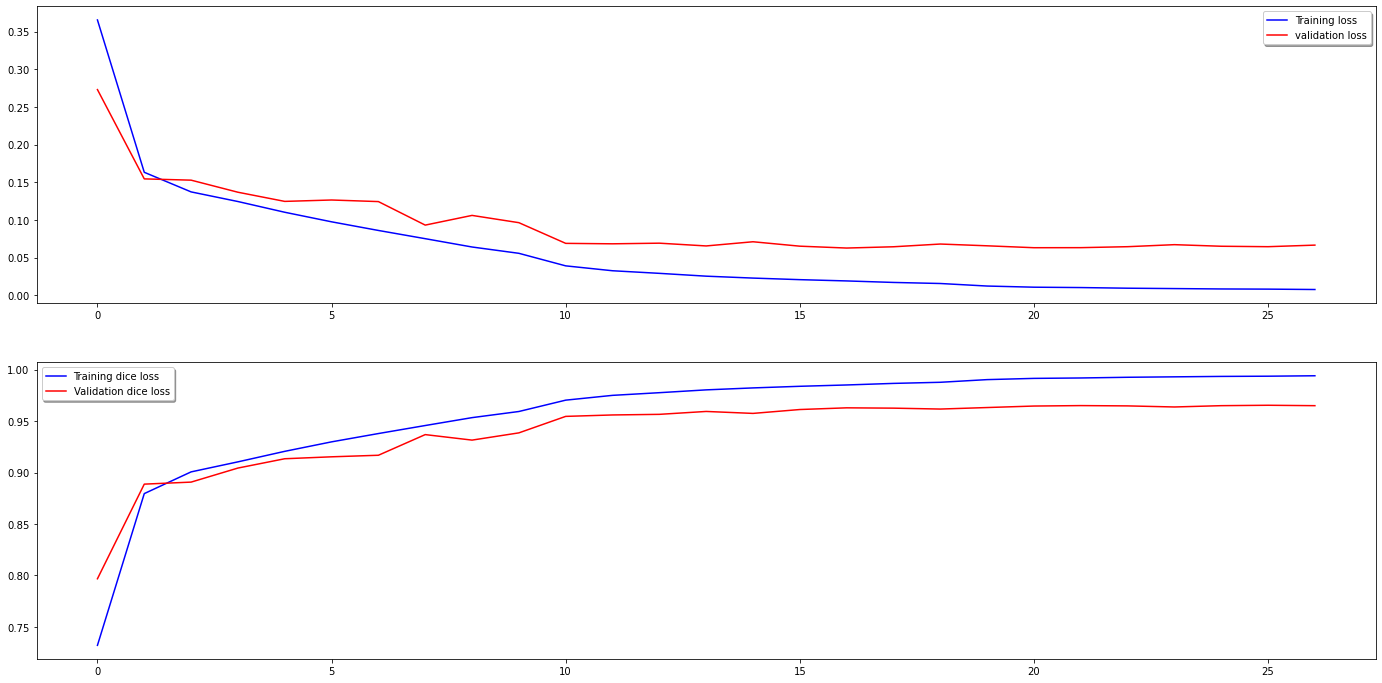

In [6]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1, figsize=(24,12))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['dice_coeff'], color='b', label="Training dice loss")
ax[1].plot(history.history['val_dice_coeff'], color='r',label="Validation dice loss")
legend = ax[1].legend(loc='best', shadow=True)


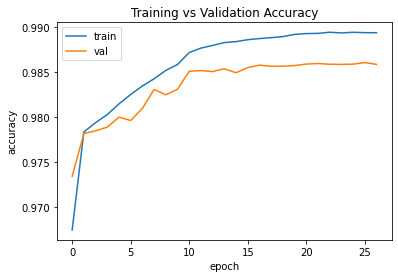

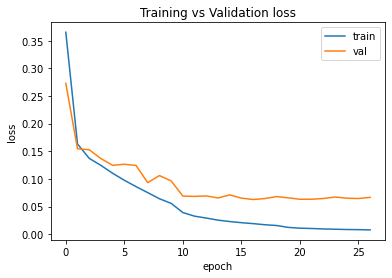

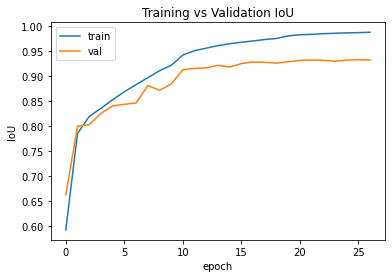

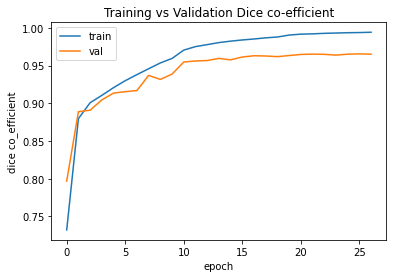

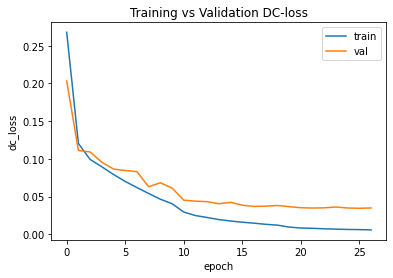

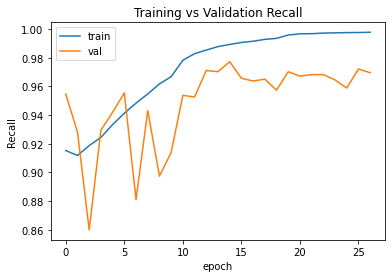

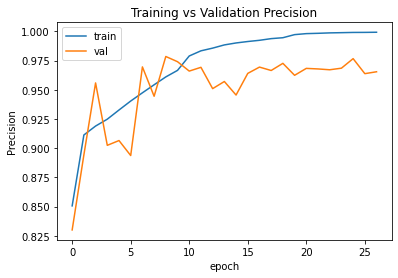

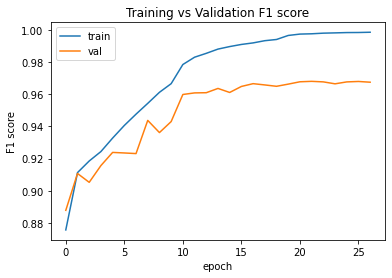

In [7]:
plt.figure(0)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Training vs Validation Accuracy", color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("accuracy", color="black")
plt.legend(["train", "val"])
plt.show()

plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training vs Validation loss", color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("loss", color="black")
plt.legend(["train", "val"])
plt.show()

plt.figure(2)
plt.plot(history.history["iou"])
plt.plot(history.history["val_iou"])
plt.title("Training vs Validation IoU", color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("IoU", color="black")
plt.legend(["train", "val"])
plt.show()

plt.figure(3)
plt.plot(history.history["dice_coeff"])
plt.plot(history.history["val_dice_coeff"])
plt.title("Training vs Validation Dice co-efficient", color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("dice co_efficient", color="black")
plt.legend(["train", "val"])
plt.show()

plt.figure(4)
plt.plot(history.history["dice_loss"])
plt.plot(history.history["val_dice_loss"])
plt.title("Training vs Validation DC-loss", color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("dc_loss", color="black")
plt.legend(["train", "val"])
plt.show()

plt.figure(5)
plt.plot(history.history["recall_m"])
plt.plot(history.history["val_recall_m"])
plt.title("Training vs Validation Recall", color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("Recall", color="black")
plt.legend(["train", "val"])
plt.show()

plt.figure(6)
plt.plot(history.history["precision_m"])
plt.plot(history.history["val_precision_m"])
plt.title("Training vs Validation Precision", color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("Precision", color="black")
plt.legend(["train", "val"])
plt.show()

plt.figure(7)
plt.plot(history.history["f1_m"])
plt.plot(history.history["val_f1_m"])
plt.title("Training vs Validation F1 score" , color="black")

plt.xlabel("epoch", color="black")
plt.ylabel("F1 score", color="black")
plt.legend(["train", "val"])
plt.show()


In [8]:
#Perdict some imgs.
pred_masks = model.predict(imgs)

1/1 [==============================] - 0s 180ms/step


In [9]:
pred_masks.shape

(32, 128, 128, 1)

In [ ]:
plt.imshow(pred_masks[0,:,:,0], cmap='gray')
plt.show()

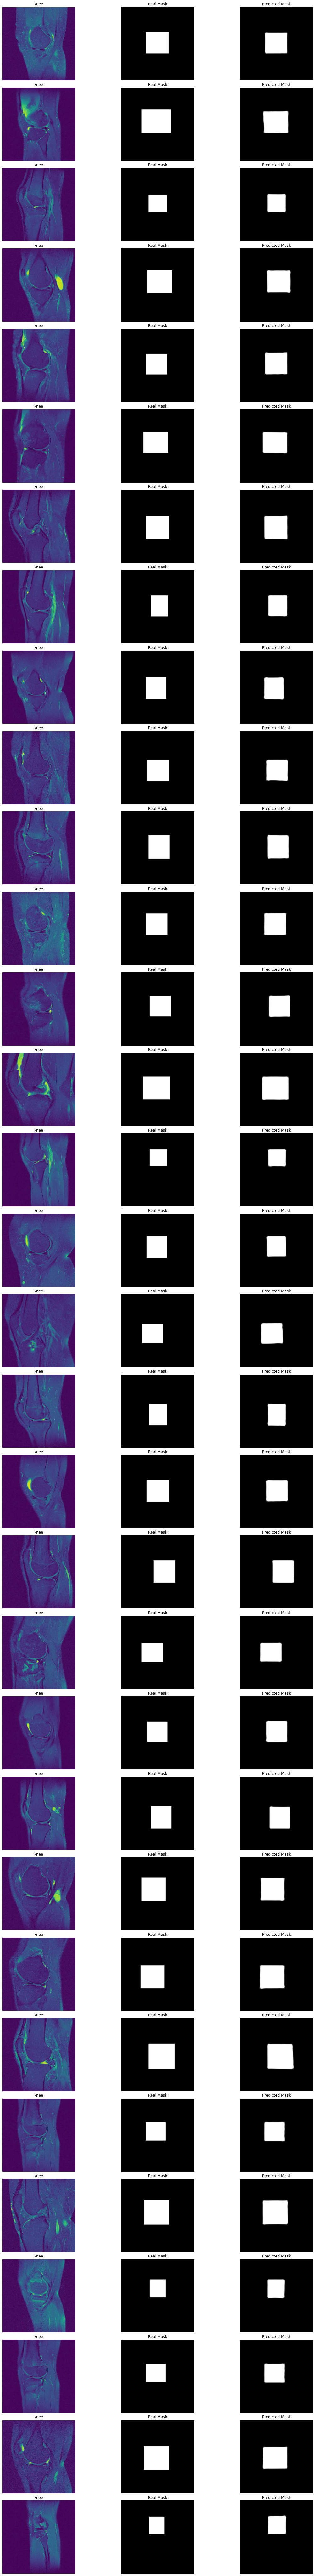

In [10]:
fig, ax = plt.subplots(32, 3, figsize=(20,150))
fig.subplots_adjust(hspace=.1, wspace=.05)
for i in range(32):
    ax[i, 0].imshow(imgs[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('knee')
    
    ax[i, 1].imshow(masks[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 

In [ ]:
import cv2
import numpy as np

# Define directory for saving predicted masks
save_dir = "/home/hcladmin/Ahsen ALi/predicted_masks/validationimages/"

# Check if directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Assume pred_masks is a list of all your predicted masks
for i in range(pred_masks.shape[0]):
    # Rescale the predicted mask
    pred_mask_rescaled = (pred_masks[i,:,:,0] * 255).astype(np.uint8)
    
    # Save the predicted mask
    cv2.imwrite(f"{save_dir}predicted_mask_{i}.png", pred_mask_rescaled)


In [ ]:
from PIL import Image
Image.fromarray(pred_mask_rescaled).save(f"{save_dir}predicted_mask_{i}.png")

In [ ]:
print(pred_masks.shape)


In [14]:
# same code above
import os
import cv2
import numpy as np

# Define directory for saving predicted masks
save_dir = "/home/hcladmin/Ahsen ALi/predicted_masks/"

# Check if directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Assume pred_masks is a list of all your predicted masks
for i, pred_mask in enumerate(pred_masks):
    # Rescale the predicted mask
    pred_mask_rescaled = (pred_mask * 255).astype(np.uint8)
    
    # Save the predicted mask
    cv2.imwrite(f"{save_dir}predicted_mask_{i}.png", pred_mask_rescaled)
